In [120]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Read Dataset

In [121]:
import os
import pandas as pd

def read_labelimg_dataset(dataset_dir):
    image_paths = []
    annotations = []

    for filename in os.listdir(dataset_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_dir, filename)
            annotation_path = os.path.join(dataset_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

            if os.path.isfile(annotation_path):
                image_paths.append(image_path)
                with open(annotation_path, 'r') as f:
                    annotation_lines = f.readlines()

                annotation_data = []
                for line in annotation_lines:
                    parts = line.strip().split()
                    label = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    # Calculate new x_min and x_max
                    x_min = x_center - (width / 2)
                    x_max = x_center + (width / 2)

                    # Calculate new y_min and y_max
                    y_min = y_center - (height / 2)
                    y_max = y_center + (height / 2)

                    annotation_data.append({'label': label, 'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max})

                annotations.append(annotation_data)

    df = pd.DataFrame({'image_path': image_paths, 'annotations': annotations})
    return df

In [122]:
dataset_dir = 'dataset_melon/'
df = read_labelimg_dataset(dataset_dir)

In [123]:
df.head()

,image_path,annotations
0,dataset_melon/melon_1.jpg,"[{'label': 0, 'x_min': 0.6900005, 'y_min': 0.4..."
1,dataset_melon/melon_10.jpg,"[{'label': 0, 'x_min': 0.34, 'y_min': 0.590000..."
2,dataset_melon/melon_100.jpg,"[{'label': 0, 'x_min': 0.380328, 'y_min': 0.52..."
3,dataset_melon/melon_101.jpg,"[{'label': 0, 'x_min': 0.10163999999999998, 'y..."
4,dataset_melon/melon_102.jpg,"[{'label': 0, 'x_min': 0.3278685, 'y_min': 0.1..."


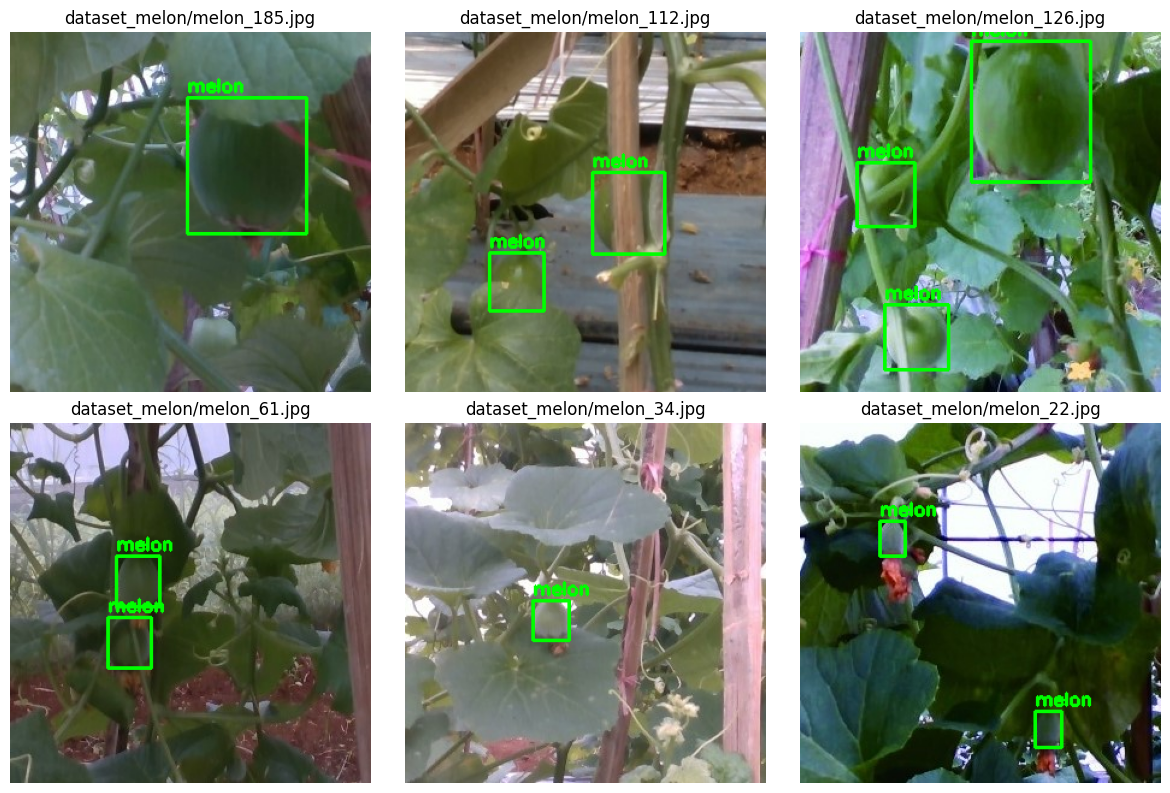

In [124]:
from pandas.core.dtypes.common import classes
# Ambil 6 gambar secara random
sample_df = df.sample(n=6, random_state=42)

def display_samples(sample_df):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, (_, row) in enumerate(sample_df.iterrows()):
        image_path = row['image_path']
        annotations = row['annotations']

        # Load the image using OpenCV
        image = cv2.imread(image_path)
        width, height, _ = image.shape

        for annotation in annotations:
            lable, x_min, y_min, x_max, y_max = annotation['label'], annotation['x_min'], annotation['y_min'], annotation['x_max'], annotation['y_max']

            x_min = int(float(x_min) * width)
            y_min = int(float(y_min) * height)
            x_max = int(float(x_max) * width)
            y_max = int(float(y_max) * height)

            if(lable == 0):
                lable = 'melon'

            # Draw a rectangle for the bounding box annotation
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Add label text to the bounding box
            image = cv2.putText(image, str(lable), (int(x_min), int(y_min) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Convert BGR to RGB for plotting with Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes and label names
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
        axes[i].set_title(image_path)

    plt.tight_layout()
    plt.show()

display_samples(sample_df)

# Split Dataset Into Train & Test

In [125]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

def read_labelimg_dataset(dataset_dir):
    image_paths = []
    annotation_paths = []

    for filename in os.listdir(dataset_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_dir, filename)
            annotation_path = os.path.join(dataset_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

            if os.path.isfile(annotation_path):
                image_paths.append(image_path)
                annotation_paths.append(annotation_path)

    df = pd.DataFrame({'image_path': image_paths, 'annotation_path': annotation_paths})
    return df


# Specify the directory containing the files
directory_path = 'dataset_melon/'

# Read the DataFrame
df = read_labelimg_dataset(directory_path)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Specify the output directories for train and test sets
train_output_dir = 'dataset/train/'
test_output_dir = 'dataset/test/'

# Create train and test output directories if they don't exist
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Copy train image and annotation files to the train output directory
for _, row in train_df.iterrows():
    source_image_path = row['image_path']
    source_annotation_path = row['annotation_path']
    destination_image_path = os.path.join(train_output_dir, os.path.basename(source_image_path))
    destination_annotation_path = os.path.join(train_output_dir, os.path.basename(source_annotation_path))
    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_annotation_path, destination_annotation_path)

# Copy test image and annotation files to the test output directory
for _, row in test_df.iterrows():
    source_image_path = row['image_path']
    source_annotation_path = row['annotation_path']
    destination_image_path = os.path.join(test_output_dir, os.path.basename(source_image_path))
    destination_annotation_path = os.path.join(test_output_dir, os.path.basename(source_annotation_path))
    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_annotation_path, destination_annotation_path)

# Save train and test DataFrames to CSV
train_df.to_csv('train/train.csv', index=False)
test_df.to_csv('test/test.csv', index=False)

# Read Train & Test

In [126]:
train_df

,image_path,annotation_path
79,dataset_melon/melon_170.jpg,dataset_melon/melon_170.txt
197,dataset_melon/melon_97.jpg,dataset_melon/melon_97.txt
38,dataset_melon/melon_133.jpg,dataset_melon/melon_133.txt
24,dataset_melon/melon_120.jpg,dataset_melon/melon_120.txt
122,dataset_melon/melon_29.jpg,dataset_melon/melon_29.txt
...,...,...
106,dataset_melon/melon_195.jpg,dataset_melon/melon_195.txt
14,dataset_melon/melon_111.jpg,dataset_melon/melon_111.txt
92,dataset_melon/melon_182.jpg,dataset_melon/melon_182.txt
179,dataset_melon/melon_80.jpg,dataset_melon/melon_80.txt


In [127]:
import os
import pandas as pd

def read_labelimg_train_test(dataset_dir):
    image_paths = []
    labels = []
    x_min = []
    y_min = []
    x_max = []
    y_max = []

    for filename in os.listdir(dataset_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_dir, filename)
            annotation_path = os.path.join(dataset_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

            if os.path.isfile(annotation_path):
                with open(annotation_path, 'r') as f:
                    annotation_lines = f.readlines()

                for line in annotation_lines:
                    parts = line.strip().split()
                    label = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    # # Calculate new x_min and x_max
                    xmin = x_center - (width / 2)
                    xmax = x_center + (width / 2)

                    # # Calculate new y_min and y_max
                    ymin = y_center - (height / 2)
                    ymax = y_center + (height / 2)

                    image_paths.append(os.path.basename(image_path))  # Extract file name only
                    labels.append(label)
                    x_min.append(xmin)
                    y_min.append(ymin)
                    x_max.append(xmax)
                    y_max.append(ymax)

    df = pd.DataFrame({'FileName': image_paths, 'label': labels, 'XMin': x_min, 'XMax': x_max, 'YMin': y_min, 'YMax': y_max})
    return df

In [128]:
train_dir = 'dataset/train'
train_df = read_labelimg_train_test(train_dir)

In [129]:
train_df

,FileName,label,XMin,XMax,YMin,YMax
0,melon_1.jpg,0,0.690001,0.963334,0.436667,0.746667
1,melon_10.jpg,0,0.340000,0.580000,0.590000,0.873333
2,melon_100.jpg,0,0.380328,0.485246,0.521311,0.662295
3,melon_101.jpg,0,0.101640,0.160656,0.095082,0.177049
4,melon_101.jpg,0,0.737704,0.855738,0.314754,0.445902
...,...,...,...,...,...,...
301,melon_98.jpg,0,0.055738,0.226230,0.711476,0.914755
302,melon_99.jpg,0,0.075410,0.160656,0.026230,0.170492
303,melon_99.jpg,0,0.757378,0.895083,0.740984,0.895082
304,melon_99.jpg,0,0.459017,0.518033,0.734426,0.822951


In [130]:
test_dir = 'dataset/test'
test_df = read_labelimg_train_test(test_dir)

In [131]:
test_df

,FileName,label,XMin,XMax,YMin,YMax
0,melon_107.jpg,0,0.311475,0.504918,0.485245,0.678689
1,melon_107.jpg,0,0.554099,0.636065,0.413114,0.491804
2,melon_112.jpg,0,0.236065,0.386885,0.613115,0.777049
3,melon_112.jpg,0,0.521311,0.721311,0.390164,0.616394
4,melon_113.jpg,0,0.249181,0.432787,0.288525,0.547541
...,...,...,...,...,...,...
75,melon_79.jpg,0,0.803334,0.870001,0.570000,0.670000
76,melon_83.jpg,0,0.468438,0.581395,0.235880,0.398672
77,melon_87.jpg,0,0.240122,0.337386,0.051672,0.170212
78,melon_87.jpg,0,0.416413,0.498480,0.401216,0.452888


In [132]:
train_df.to_csv('train/train.csv', index = False)
test_df.to_csv('test/test.csv', index = False)

# Add ClassName Column Into Train & Test

In [133]:
train_df['ClassName'] = ''
train_df.loc[train_df['label'] == 0, 'ClassName'] = 'melon'

In [134]:
test_df['ClassName'] = ''
test_df.loc[test_df['label'] == 0, 'ClassName'] = 'melon'

In [135]:
train_df = train_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']].copy()
test_df = test_df[['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName']].copy()

In [136]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,melon_1.jpg,0.690001,0.963334,0.436667,0.746667,melon
1,melon_10.jpg,0.340000,0.580000,0.590000,0.873333,melon
2,melon_100.jpg,0.380328,0.485246,0.521311,0.662295,melon
3,melon_101.jpg,0.101640,0.160656,0.095082,0.177049,melon
4,melon_101.jpg,0.737704,0.855738,0.314754,0.445902,melon


In [137]:
test_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,melon_107.jpg,0.311475,0.504918,0.485245,0.678689,melon
1,melon_107.jpg,0.554099,0.636065,0.413114,0.491804,melon
2,melon_112.jpg,0.236065,0.386885,0.613115,0.777049,melon
3,melon_112.jpg,0.521311,0.721311,0.390164,0.616394,melon
4,melon_113.jpg,0.249181,0.432787,0.288525,0.547541,melon


In [138]:
train_df.to_csv('train/train.csv', index = False)
test_df.to_csv('test/test.csv', index = False)

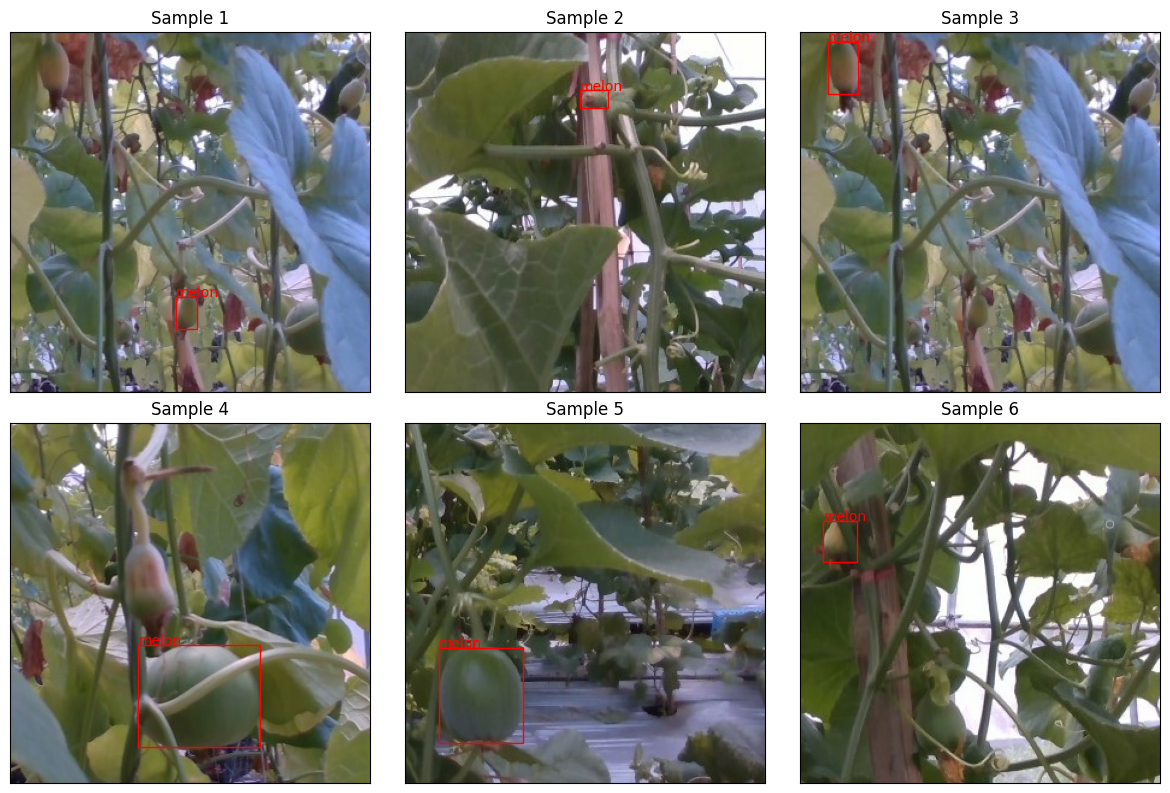

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axes
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
data_path = 'dataset/train'

# Select 6 random samples from the DataFrame
samples = train_df.sample(n=6)

# Iterate over the samples
for i, (_, sample) in enumerate(samples.iterrows()):
    # Read image file and get bounding box information
    filename = sample['FileName']
    image_path = data_path + '/' + filename
    image = plt.imread(image_path)
    height, width, _ = image.shape
    xmin = (sample['XMin'] * width)
    xmax = (sample['XMax'] * width)
    ymin = (sample['YMin'] * height)
    ymax = (sample['YMax'] * height)
    class_name = sample['ClassName']

    # Load and plot the image
    # image_path = data_path + '/' + filename
    axes[i].imshow(image)
    axes[i].set_title(f"Sample {i+1}")

    # Create a rectangle patch for each bounding box and add it to the plot
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
    axes[i].add_patch(rect)
    axes[i].text(xmin, ymin, class_name, fontsize=10, color='r')

    # Remove axis ticks
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()


In [140]:
print("DataFrame shape:", df.shape)

DataFrame shape: (200, 2)


In [141]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,melon_1.jpg,0.690001,0.963334,0.436667,0.746667,melon
1,melon_10.jpg,0.340000,0.580000,0.590000,0.873333,melon
2,melon_100.jpg,0.380328,0.485246,0.521311,0.662295,melon
3,melon_101.jpg,0.101640,0.160656,0.095082,0.177049,melon
4,melon_101.jpg,0.737704,0.855738,0.314754,0.445902,melon


# Make Annotation.txt from Train & Test

In [142]:
train_df = pd.read_csv('train/train.csv')

# for training
with open("train/annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('dataset/train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      google_colab_file_path = 'dataset/train/'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [143]:
train_df = pd.read_csv('train/train.csv')

In [144]:
train_df

,FileName,XMin,XMax,YMin,YMax,ClassName
0,melon_1.jpg,0.690001,0.963333,0.436667,0.746667,melon
1,melon_10.jpg,0.340000,0.580000,0.590000,0.873333,melon
2,melon_100.jpg,0.380328,0.485246,0.521311,0.662295,melon
3,melon_101.jpg,0.101640,0.160656,0.095082,0.177049,melon
4,melon_101.jpg,0.737704,0.855738,0.314754,0.445902,melon
...,...,...,...,...,...,...
301,melon_98.jpg,0.055738,0.226230,0.711476,0.914755,melon
302,melon_99.jpg,0.075410,0.160656,0.026230,0.170492,melon
303,melon_99.jpg,0.757378,0.895083,0.740984,0.895082,melon
304,melon_99.jpg,0.459017,0.518033,0.734426,0.822951,melon


In [145]:
test_df = pd.read_csv('test/test.csv')

# for test
with open("test/test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      img = cv2.imread('dataset/test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      google_colab_file_path = 'dataset/test/'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')